In [109]:
import pickle
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
import pandas as pd
from collections import Counter
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
import re
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import logging
import sys
import seaborn as sns
from wordcloud import WordCloud
import nltk

# Data Exploration

In [110]:
# Load the dataset
df = pd.read_csv("/kaggle/input/resume-dataset/Resume/Resume.csv")

# Display first 5 rows of the dataset
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [111]:
# create list of all categories
categories = np.sort(df['Category'].unique())
categories

array(['ACCOUNTANT', 'ADVOCATE', 'AGRICULTURE', 'APPAREL', 'ARTS',
       'AUTOMOBILE', 'AVIATION', 'BANKING', 'BPO', 'BUSINESS-DEVELOPMENT',
       'CHEF', 'CONSTRUCTION', 'CONSULTANT', 'DESIGNER', 'DIGITAL-MEDIA',
       'ENGINEERING', 'FINANCE', 'FITNESS', 'HEALTHCARE', 'HR',
       'INFORMATION-TECHNOLOGY', 'PUBLIC-RELATIONS', 'SALES', 'TEACHER'],
      dtype=object)

In [112]:
# Check the data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


In [113]:
# Check for missing values
df.isnull().sum()

ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

In [114]:
# Get basic statistical information about the numerical columns
print(df.describe())

                 ID
count  2.484000e+03
mean   3.182616e+07
std    2.145735e+07
min    3.547447e+06
25%    1.754430e+07
50%    2.521031e+07
75%    3.611444e+07
max    9.980612e+07


Text(0.5, 1.0, 'Boxplot of ID by Category')

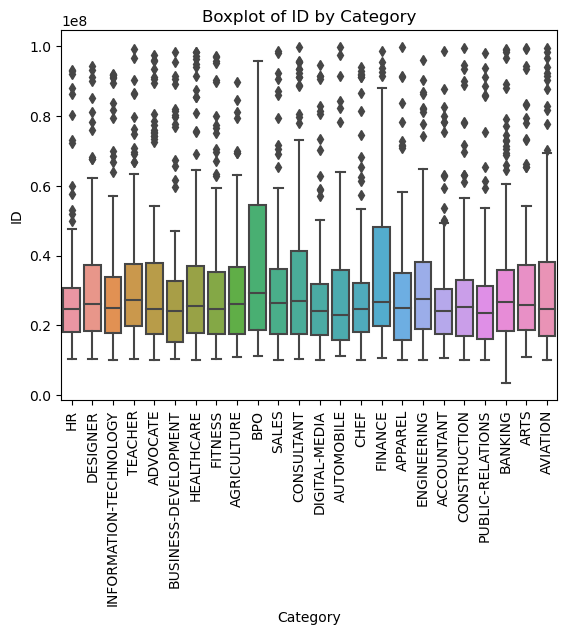

In [115]:
# Create a boxplot of 'ID' by 'Category'
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(x='Category', y='ID', data=df)
plt.xticks(rotation=90)  # rotate the x-axis labels
plt.title('Boxplot of ID by Category')

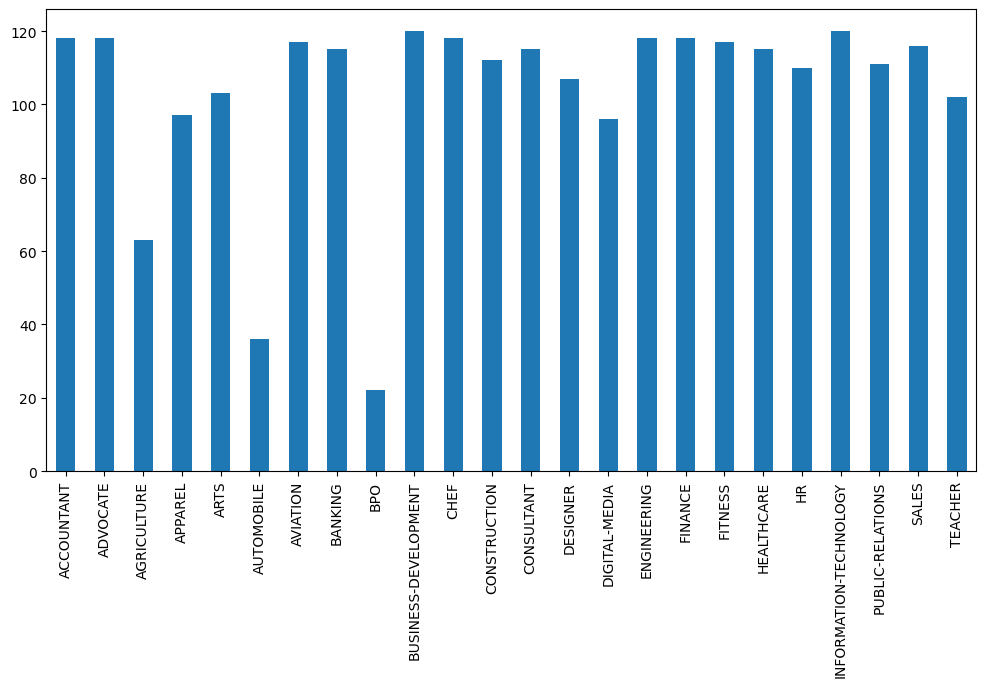

In [116]:
df['Category'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.show()

# Pre-processing

In [117]:
def clean_resume(resume_text):
    # Remove URLs, hashtags, mentions, and punctuation
    resume_text = re.sub(
        r"http\S+|#\S+|@\S+|[%s]" % re.escape(string.punctuation),
        " ",
        resume_text,
        flags=re.IGNORECASE,
    )
    # Remove non-ASCII characters
    resume_text = re.sub(r"[^\x00-\x7f]", " ", resume_text)
    # Remove extra whitespace
    resume_text = re.sub("\s+", " ", resume_text)
    return resume_text

In [118]:
# preprocessing text
resumes = df['Resume_str'].apply(clean_resume)
df.head()

df.to_csv('preprocessed_dataset.csv', index=False)

# create list of all categories
categories = np.sort(df['Category'].unique())
categories

array(['ACCOUNTANT', 'ADVOCATE', 'AGRICULTURE', 'APPAREL', 'ARTS',
       'AUTOMOBILE', 'AVIATION', 'BANKING', 'BPO', 'BUSINESS-DEVELOPMENT',
       'CHEF', 'CONSTRUCTION', 'CONSULTANT', 'DESIGNER', 'DIGITAL-MEDIA',
       'ENGINEERING', 'FINANCE', 'FITNESS', 'HEALTHCARE', 'HR',
       'INFORMATION-TECHNOLOGY', 'PUBLIC-RELATIONS', 'SALES', 'TEACHER'],
      dtype=object)

In [119]:
df['Category'].value_counts()

INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: Category, dtype: int64

In [120]:
# create new df for corpus and category
df_categories = [df[df['Category'] == category].loc[:, ['Resume_str', 'Category']] for category in categories]
df_categories[10]

,Resume_str,Category
1357,CHEF Career Focus I am a nu...,CHEF
1358,CHEF Summary Customer-o...,CHEF
1359,CHEF Career Overview De...,CHEF
1360,CHEF Summary Experienced ca...,CHEF
1361,RM Roxanne Mejia Summary ...,CHEF
...,...,...
1470,OWNER/CHEF Summary Chef wit...,CHEF
1471,KINDERGARTEN TEACHER Professi...,CHEF
1472,SUBSTITUTE PARA PROFESSIONAL Su...,CHEF
1473,EXECUTIVE CHEF-PARTNER Summ...,CHEF


In [121]:
# word frequency for each category
def wordfreq(df):
    count = df['Resume_str'].str.split(expand=True).stack().value_counts().reset_index()
    count.columns = ['Word', 'Frequency']

    return count.head(10)

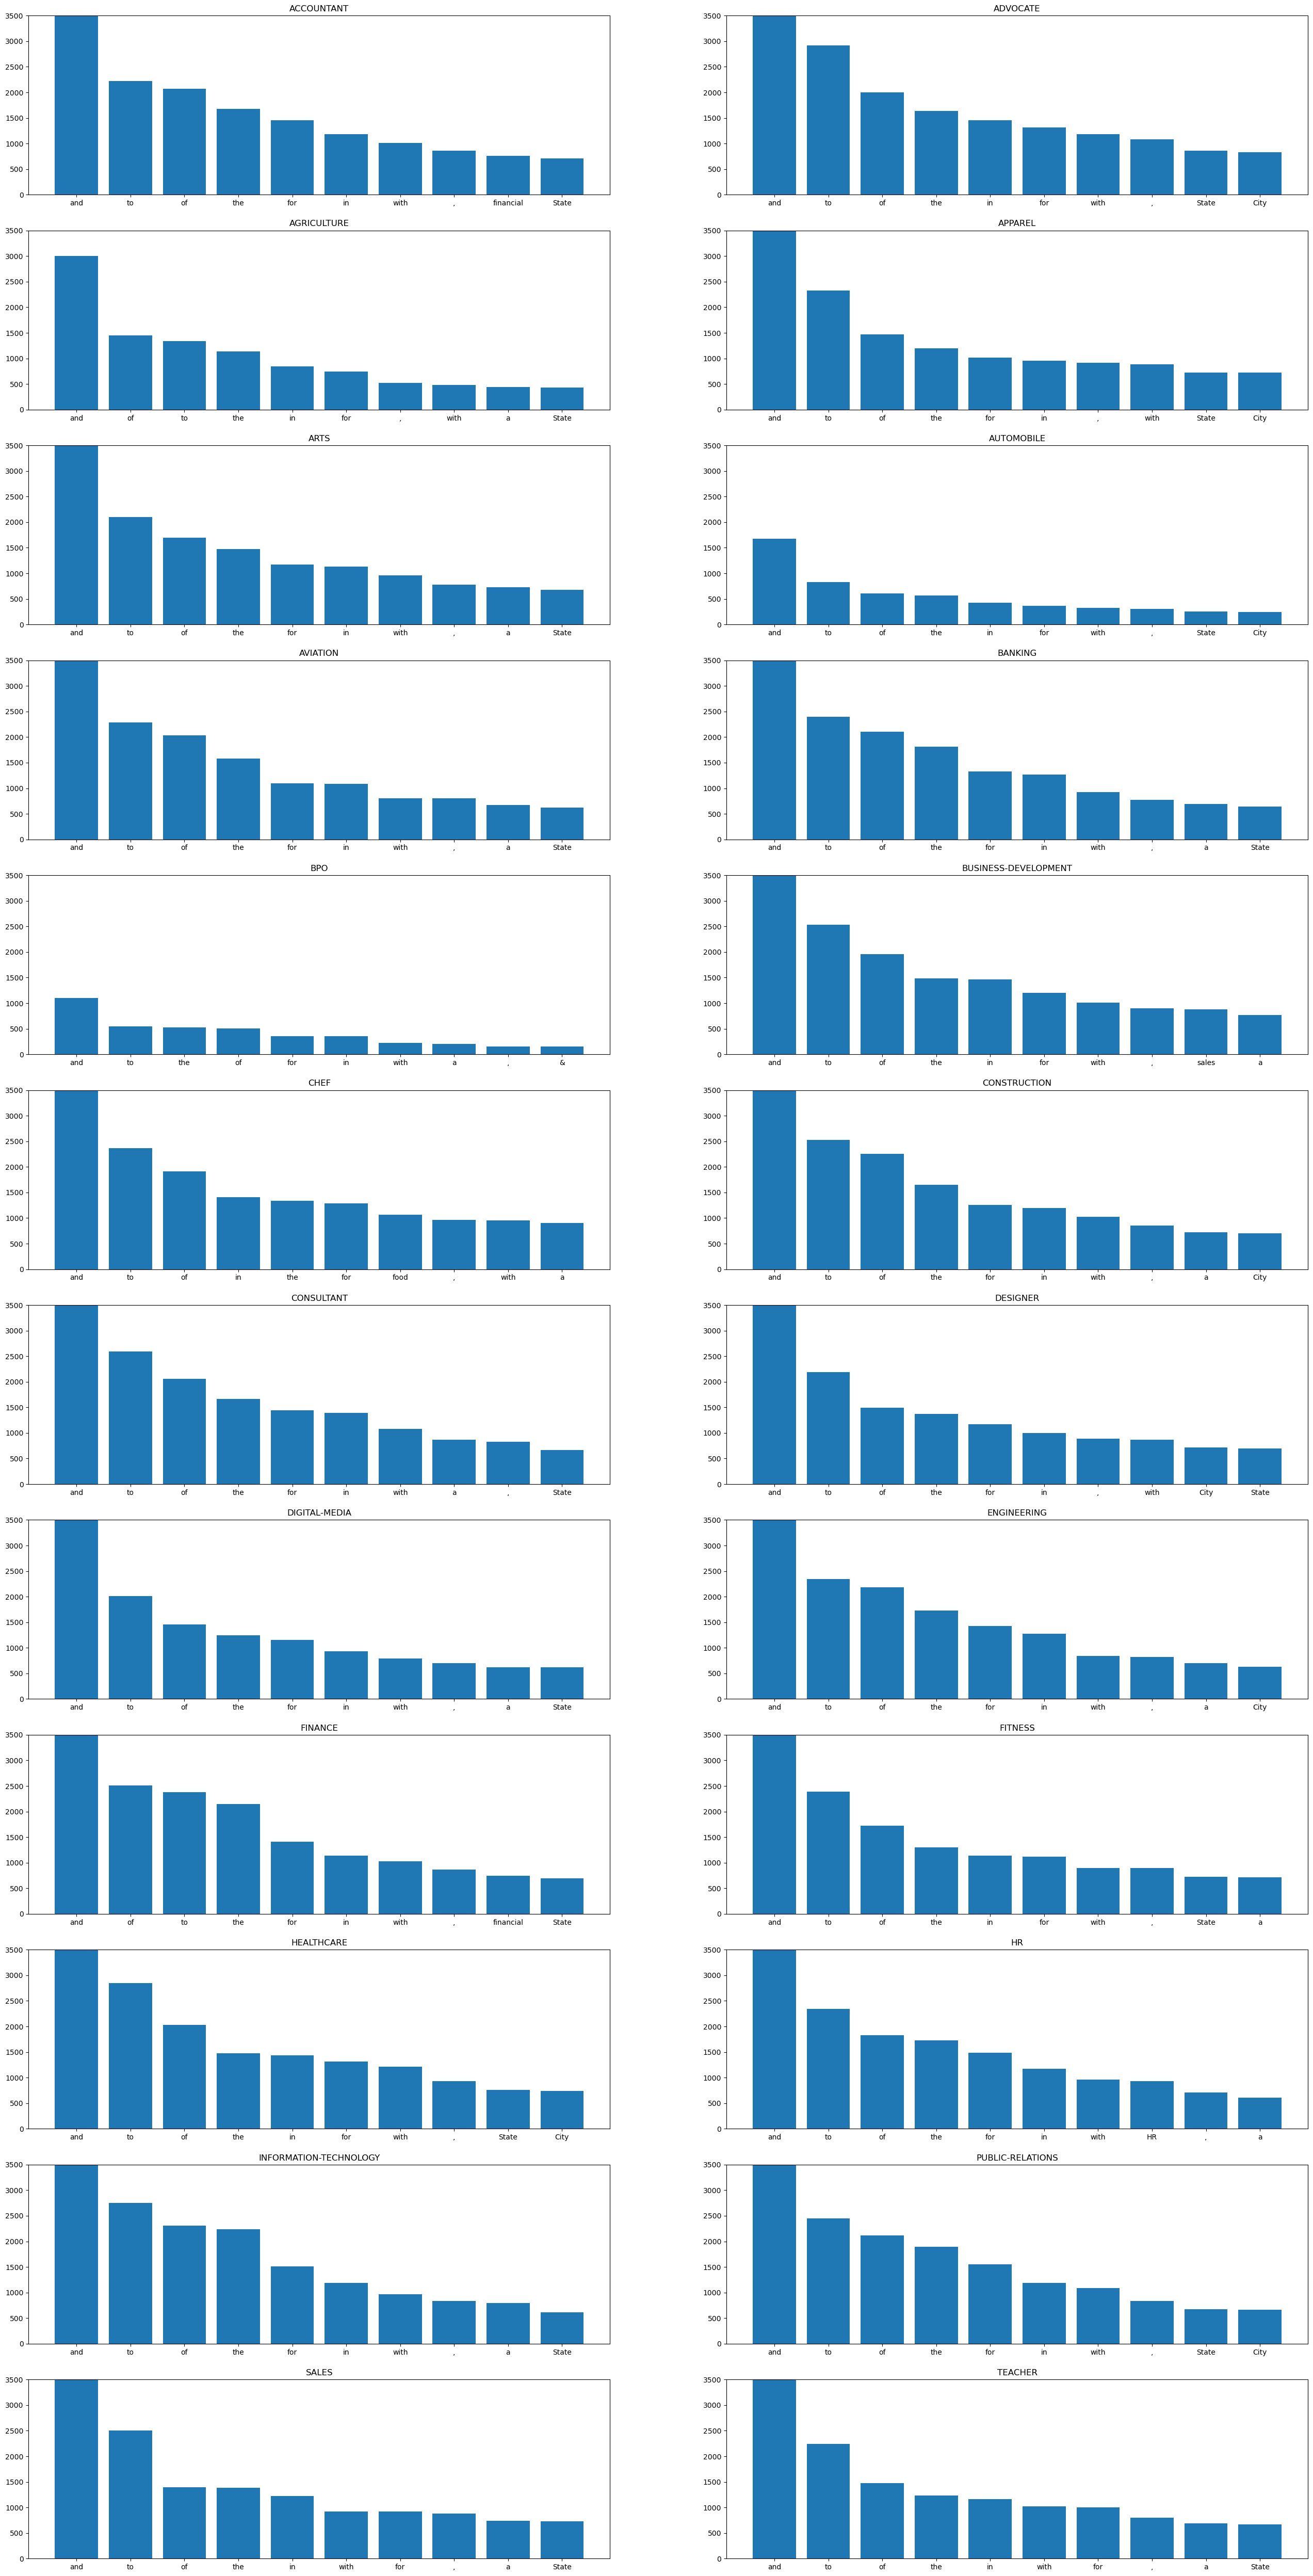

In [122]:
fig = plt.figure(figsize=(32, 64))

for i, category in enumerate(np.sort(df['Category'].unique())):
    wf = wordfreq(df_categories[i])

    fig.add_subplot(12, 2, i + 1).set_title(category)
    plt.bar(wf['Word'], wf['Frequency'])
    plt.ylim(0, 3500)

plt.show()
plt.close()

In [123]:
MODEL_OUT_PATH = 'trained_model.pkl'

In [124]:
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# Model Training

In [125]:
def train_resume_model(resumes_df: list):
    """
    Train a classifier to classify resumes.

    Parameters:
        - resumes_df: list of tuples, where each tuple consists of a description and a category

    Returns:
        - report: dict, containing the keys 'accuracy', 'precision', and 'recall' and their respective values
    """

    # Encode the categories as integers

    cleaned_resumes = resumes_df['Resume_str'].apply(clean_resume)
    y = resumes_df['Category']


    # Vectorize the descriptions
    vectorizer = CountVectorizer(stop_words="english")
    x = vectorizer.fit_transform(cleaned_resumes)



    # Split the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

    # Create the base classifiers

    clf_1 = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=4, min_samples_leaf=2)
    clf_2 = AdaBoostClassifier(random_state=1, n_estimators=100, learning_rate=1)
    clf_3 = XGBClassifier(n_estimators=196, max_depth=4, learning_rate=0.03)
    clf_4 = LogisticRegression(max_iter=1000)
    clf_5 = DecisionTreeClassifier()

    # Create the ensemble classifier
    ensemble = VotingClassifier(estimators=[
        ('rfc', clf_1),
        ('abc', clf_2),
        ('xbc', clf_3),
        ('lrc', clf_4),
        ('dcc', clf_5)
    ], voting='soft')

    # Fit the ensemble classifier to the training data
    ensemble.fit(x_train, y_train)

    # Save the trained model so we can use it later
    with open(MODEL_OUT_PATH, "wb") as f:
        pickle.dump((ensemble, vectorizer), f)

    # Make predictions on the test data
    predictions = ensemble.predict(x_test)

    # Compute the classification report
    classification_report = metrics.classification_report(y_test, predictions, zero_division=1, output_dict=True)

    logging.info("Training of model has finished")

    return classification_report

In [126]:
df = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv', encoding='utf-8')
# shuffle the dataset to to a further representative of reality
df = shuffle(df)
trained_model = train_resume_model(df)

In [127]:
accuracy = trained_model['accuracy']
precision = trained_model["weighted avg"]["precision"]
recall = trained_model["weighted avg"]["recall"]

print(accuracy)
print(precision)
print(recall)
#assert accuracy and precision and recall > 0.7


0.6981891348088531
0.6863382185562351
0.6981891348088531


# Classification Dataframe

In [128]:
def classify_resumes(resumes_df: pd.DataFrame) -> pd.DataFrame:
    with open(MODEL_OUT_PATH, "rb") as f:
        model, vectorizer = pickle.load(f)
    categories = model.classes_
    x = vectorizer.transform(resumes_df["Resume_str"].apply(clean_resume))
    predictions = model.predict_proba(x)
    prediction = pd.DataFrame(
    columns=[
        "ID",
        "category_1",
        "proba_1",
        "category_2",
        "proba_2",
        "category_3",
        "proba_3",
    ])
    predicted_categories = model.predict(x)
    for resume_id, probas,pred_cat in zip(resumes_df["ID"], predictions,predicted_categories):
        top_3_categories = probas.argsort()[-3:][::-1]
        top_3_probas = probas[top_3_categories]
        prediction = prediction.append(
            {
                "ID": resume_id,
                "category_1": categories[top_3_categories[0]],
                "proba_1": top_3_probas[0],
                "category_2": categories[top_3_categories[1]],
                "proba_2": top_3_probas[1],
                "category_3": categories[top_3_categories[2]],
                "proba_3": top_3_probas[2],
            },
            ignore_index=True,
        )
    return prediction

In [129]:
classified_resumes = classify_resumes(df)
classified_resumes.describe()

/tmp/ipykernel_32/1710133437.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction = prediction.append(
/tmp/ipykernel_32/1710133437.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction = prediction.append(
/tmp/ipykernel_32/1710133437.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction = prediction.append(
/tmp/ipykernel_32/1710133437.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction = prediction.append(
/tmp/ipykernel_32/1710133437.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction = pred

,proba_1,proba_2,proba_3
count,2484.000000,2484.000000,2484.000000
mean,0.642185,0.052815,0.029538
std,0.113371,0.055066,0.022189
min,0.213107,0.011495,0.011374
25%,0.638963,0.024979,0.019815
50%,0.676290,0.033211,0.023490
75%,0.703224,0.050495,0.028839
max,0.822602,0.339312,0.208131


In [130]:
def add_original_category_and_fp(resumes):
    """
    Add the original category for each resume and assign False positive based on comparison of original category and the first predicted category
    Parameters:
        - resumes: Dataframe containing the predicted categories of the resumes
    Returns:
        - Dataframe containing the ID of the resume, the top 5 likely categories with their respective probabilities, the original category, and fp column
    """
    # Get the original categories from the original dataframe
    categories = df[['ID', 'Category']]
    # Merge the original categories into the classified resumes dataframe
    resumes = resumes.merge(categories, on='ID', how='left')
    # Re-initialize fp column to be False for all rows
    resumes = resumes.assign(fp=False)
    # Iterate through each row to check if the original category is the same as the first predicted category
    for index, row in resumes.iterrows():
        if not row['Category'] == row['category_1']:
            # If not, then set the fp column to be True for that row
            resumes.at[index, 'fp'] = True
    return resumes

# Call the function to add original category and fp column to the classified_resumes dataframe
classified_resumes = add_original_category_and_fp(classified_resumes)

# Get only the rows where fp column is True
false_positives = classified_resumes[classified_resumes['fp'] == True]

# Print the number and percentage of false positives
print(f"The amount of false positives (fp) is {false_positives.count()['ID']}")
print(f"The percentage of false positives (fp) is: {false_positives.count()['ID'] / classified_resumes.count()['ID'] * 100} %")

false_positives.describe()

The amount of false positives (fp) is 150
The percentage of false positives (fp) is: 6.038647342995169 %


,proba_1,proba_2,proba_3
count,150.000000,150.000000,150.000000
mean,0.350945,0.162395,0.082799
std,0.132736,0.069009,0.047055
min,0.213107,0.026093,0.020306
25%,0.233076,0.107864,0.046099
50%,0.310839,0.174302,0.071152
75%,0.414705,0.214333,0.104010
max,0.698514,0.333828,0.208131


# Single Data Prediction

In [131]:
import pickle
import pandas as pd
import re
import string
import random

MODEL_OUT_PATH = 'trained_model.pkl'

def clean_resume(resume_text):
    # Remove URLs, hashtags, mentions, and punctuation
    resume_text = re.sub(
        r"http\S+|#\S+|@\S+|[%s]" % re.escape(string.punctuation),
        " ",
        resume_text,
        flags=re.IGNORECASE,
    )
    # Remove non-ASCII characters
    resume_text = re.sub(r"[^\x00-\x7f]", " ", resume_text)
    # Remove extra whitespace
    resume_text = re.sub("\s+", " ", resume_text)
    return resume_text

def classify_single_resume(resume_text):
    with open(MODEL_OUT_PATH, "rb") as f:
        model, vectorizer = pickle.load(f)
    
    cleaned_resume = clean_resume(resume_text)
    x = vectorizer.transform([cleaned_resume])
    predicted_proba = model.predict_proba(x)
    predicted_categories = model.classes_
    
    return predicted_categories, predicted_proba[0]

# Load the dataframe containing test data
test_data = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv', encoding='utf-8')

# Select a random test data point
random_index = random.randint(0, len(test_data) - 1)
random_resume = test_data.loc[random_index, 'Resume_str']
ground_truth_label = test_data.loc[random_index, 'Category']

# Classify the random resume
predicted_labels, predicted_probabilities = classify_single_resume(random_resume)
max_probability = max(predicted_probabilities)
max_probability_index = predicted_probabilities.argmax()
class_name_of_max_probability = predicted_labels[max_probability_index]

print("Randomly Selected Resume:")
print("Resume Text:", random_resume)
print("\nPredicted Labels and Probabilities:")
for label, prob in zip(predicted_labels, predicted_probabilities):
    print(f"Label: {label}, Probability: {prob:.4f}")

print("\nMaximum Probability:", max_probability)
print("Class Name of Maximum Probability:", class_name_of_max_probability)
print("Ground Truth Label:", ground_truth_label)


Randomly Selected Resume:
Resume Text:                      

Predicted Labels and Probabilities:
Label: ACCOUNTANT, Probability: 0.0073
Label: ADVOCATE, Probability: 0.0169
Label: AGRICULTURE, Probability: 0.0189
Label: APPAREL, Probability: 0.0176
Label: ARTS, Probability: 0.0295
Label: AUTOMOBILE, Probability: 0.0160
Label: AVIATION, Probability: 0.0327
Label: BANKING, Probability: 0.0191
Label: BPO, Probability: 0.0127
Label: BUSINESS-DEVELOPMENT, Probability: 0.5240
Label: CHEF, Probability: 0.0207
Label: CONSTRUCTION, Probability: 0.0405
Label: CONSULTANT, Probability: 0.0192
Label: DESIGNER, Probability: 0.0311
Label: DIGITAL-MEDIA, Probability: 0.0189
Label: ENGINEERING, Probability: 0.0232
Label: FINANCE, Probability: 0.0146
Label: FITNESS, Probability: 0.0205
Label: HEALTHCARE, Probability: 0.0149
Label: HR, Probability: 0.0144
Label: INFORMATION-TECHNOLOGY, Probability: 0.0156
Label: PUBLIC-RELATIONS, Probability: 0.0142
Label: SALES, Probability: 0.0366
Label: TEACHER, Prob